In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.integrate import quad
from scipy.fft import fft, ifft
from scipy.interpolate import interp1d
import scipy.integrate as integrate
from functools import partial
from scipy.optimize import minimize, fsolve
import tqdm
import yfinance as yf
import yahoo_fin.options as ops

%matplotlib inline

plt.style.use('ggplot')
sns.set_palette('mako')
sns.set_style('darkgrid')

In [2]:
import exact_methods as exm
import characteristics_functions as chf
import monte_carlo_methods as mcm
import stochastic_processes as stch

In [ ]:
expiration_dates = ops.get_expiration_dates("aapl")

In [ ]:
expiration_dates

In [ ]:
s0_apple = 150.62 #15.03.2022

In [ ]:
apple_option_calls = ops.get_calls("AAPL", 'April 1, 2022')

In [ ]:
apple_option_calls.head()

In [ ]:
apple_option_calls.to_csv('apple_option_call_april_01_2022.csv')

In [ ]:
apple_strikes = apple_option_calls.loc[:, 'Strike']
apple_market_price = apple_option_calls.loc[:, 'Last Price']

In [ ]:
apple_spread = apple_option_calls.loc[:, 'Ask'] - apple_option_calls.loc[:, 'Bid']

In [ ]:
numberPaths = 200
N = 500
T = 1
r = 0.05
rho1 = 0.01

type_option = 'c'

In [ ]:
# r, kappa, gamma, vbar, v0, rho

def error_fHM(x, prices, strikes, s0, spread):
    cf = chf.ChFHestonModel(x[0], 1, x[1], x[2], x[3], x[4], x[5])
    
    price_calib = exm.CallPutOptionPriceCOS(cf, type_option, s0, x[0], 1, strikes, N, 8).T[0]
    
    return np.mean(((price_calib - prices)/spread)**2)

In [ ]:
init_vals = [0.05, 4, 0.3, 0.4, 0.3, -0.7]
bounds = ((0.01, 0.1), (0.1, 10), (0.2, 1), (0.01, 1), (0.01, 1), (-0.9, 0.9))

params_heston_COS = minimize(error_fHM, x0=init_vals, args=(apple_market_price, apple_strikes, s0_apple, apple_spread),
                             bounds=bounds, tol=1e-4, options={"maxiter": 1000})

params_heston_COS

In [ ]:
r, kappa, gamma, vbar, v0, rho = params_heston_COS.x

In [ ]:
cf = chf.ChFHestonModel(r, 1, kappa, gamma, vbar, v0, rho)
option_heston_cos = exm.CallPutOptionPriceCOS(cf, type_option, s0_apple, r, 1, apple_strikes, N, 8).T[0]

In [ ]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(apple_strikes, apple_market_price, label='Initial Prices')
plt.plot(apple_strikes, option_heston_cos, color='green', label='Heston COS')
        
plt.title('Option Pricing for AAPL with Heston COS', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [9]:
tau = 1
T = 1

k = 1
gamma = 0.4
vb = 0.04

kr = 1
gammar = 0.1
mur = 0.3

krho = 1
murho = 0.5
sigmarho = 0.2
rho4 = 0.5
rho5 = 0.1

xip = 1
muJ = 0
sigmaJ = 1

v0 = 0.05
r0 = 0.05
rho0 = -0.8

In [3]:
def calibrationBates_SIR_SC(CP, kr, rho0, krho, xip, muJ, sigmaJ, r0, K, marketPrice, s0, T, P0T):
    K = np.array(K)
    marketPrice = np.array(marketPrice)
    # x = [k, gamma, vb, gammar, mur, murho, sigmarho, rho4, rho5, v0]
    f_obj = lambda x: errorFun(CP, tau, T, x[0], x[1], x[2], kr, x[3], x[4], krho, x[5], x[6], x[7], x[8], xip, muJ,
                               sigmaJ, x[9], r0, rho0, K, marketPrice, s0, P0T)
       
    # Random initial guess

    #[k, gamma, vb, gammar, mur, murho, sigmarho, rho4, rho5, v0]
    initial = np.array([1.0, 0.3, 0.04, 0.3, 0.1, 0.2, 0.5, 0.1, 0.1, 0.05])
    pars  = minimize(f_obj, initial, method='nelder-mead', options = {'xtol': 1e-05, 'disp': False,'maxiter':100})
    print(pars)
    
    k_est = pars.x[0]
    gamma_est = pars.x[1]
    vb_est = pars.x[2]
    gammar_est = pars.x[3]
    mur_est = pars.x[4]
    murho_est = pars.x[5]
    sigmarho_est = pars.x[6]
    rho4_est = pars.x[7]
    rho5_est = pars.x[8]
    v0_est = pars.x[9]
    
    parmCalibr =  {"gamma":gamma_est,"vBar":vb_est,"Rxv":k_est,\
                   "v0":v0_est,'ErrorFinal':pars.fun}
    return parmCalibr

In [4]:
def errorFun(CP, tau, T, k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0, K, marketPrice, s0, P0T):
    if K is not np.array:
        K = np.array(K).reshape([len(K),1])
    
    # Settings for the COS method

    N = 200
    L = 10 
    cf = chf.ChFBates_StochIR_StochCor(tau, T, k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0)
    valCOS = exm.optionPriceCOSMthd_StochIR(cf, CP, s0, T, K, N, L, P0T(T))
    
    # Error is defined as the difference between the market and the model

    errorVector = valCOS - marketPrice
    
    # Target value is a norm of the error vector

    value = np.linalg.norm(errorVector)   
    print("Total Error = {0}".format(value))
    return value

In [5]:
tau = 1
T = 1
kr = 1
krho = 1

xip = 1
muJ = 0
sigmaJ = 1

r0 = 0.05
rho0 = -0.8
CP  = 'c'

P0T = lambda T: np.exp(0.0012*T+0.0007)

K = [110, 120, 125, 200]
s0 = 100
marketPrice = [45,43,38,5]

calibratedParms =  calibrationBates_SIR_SC(CP, kr, rho0, krho, xip, muJ, sigmaJ, r0, K, marketPrice, s0, T, P0T)
    
gamma = calibratedParms.get('gamma')
vb  = calibratedParms.get('vBar')
k   = calibratedParms.get('k')
v0    = calibratedParms.get('v0')
errorH1HW = calibratedParms.get('ErrorFinal') 

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

/Users/kirillzakharov/Desktop/Stochastic Calculus/characteristics_functions.py:67: RuntimeWarning: divide by zero encountered in true_divide
  dFun = gamma * d1 * ( np.exp(-k*T)*(v0 - vb)/(krho + k) + vb/krho + np.exp(-k*T)*(vb - v0)/(krho + k - l1) - vb/(krho - l1) + \
/Users/kirillzakharov/Desktop/Stochastic Calculus/characteristics_functions.py:67: RuntimeWarning: invalid value encountered in true_divide
  dFun = gamma * d1 * ( np.exp(-k*T)*(v0 - vb)/(krho + k) + vb/krho + np.exp(-k*T)*(vb - v0)/(krho + k - l1) - vb/(krho - l1) + \
/Users/kirillzakharov/Desktop/Stochastic Calculus/characteristics_functions.py:68: RuntimeWarning: divide by zero encountered in true_divide
  (- np.exp(-k*T)*(v0-vb)/(k + krho) - vb/krho + vb/(krho - l1) - np.exp(-k*T)*(vb-v0)/(k + krho - l1) ) )
/Users/kirillzakharov/Desktop/Stochastic Calculus/characteristics_functions.py:68: RuntimeWarning: invalid value encountered in true_divide
  (- np.exp(-k*T)*(v0-vb)/(k + krho) - vb/krho + vb/(krho - l1) - np.ex

ValueError: operands could not be broadcast together with shapes (1,99) (200,0) 

In [47]:
z = np.linspace(0, 1, 100)
u = np.linspace(0, 10, 11).reshape([11,1])
N = 15

# k = np.linspace(0,N-1,N).reshape([N,1])  
# u = k * np.pi / 1 

E_val=lambda z1,u: E(u,z1,lambd,gamma,Rxsigma,Rrsigma,Rxr,eta,kappa,sigmabar)
f_I21 = lambda z, u: np.exp((T-z)) * u
I21 = integrate.trapz(np.real(f_I21(z, u)), z).reshape(u.size,1)

In [48]:
I21

array([[ 0.        ],
       [ 1.71829644],
       [ 3.43659288],
       [ 5.15488931],
       [ 6.87318575],
       [ 8.59148219],
       [10.30977863],
       [12.02807507],
       [13.74637151],
       [15.46466794],
       [17.18296438]])

In [11]:
len(np.array(list(map(lambda z: f_I21(z, 1), z))))

100

In [38]:
def EFun(tau, u, k, gamma):
    # e1 = e1(u)
    # e2 = e2(u)
    i = complex(0, 1)
    e1 = np.sqrt(k**2 + gamma**2 * (u**2 + i*u))
    e2 = (k - e1) / (k + e1)

    eFun = ((k - e1) / gamma**2) * (1 - np.exp(-e1*tau))/(1 - e2 * np.exp(-e1*tau))
    return eFun

def CFun(tau, u, kr, gammar):
    i = complex(0, 1)
    c1 = np.sqrt(kr**2 + gammar**2 * (u**2 + i*u))
    c2 = (kr - c1) / (kr + c1)

    cFun = ((kr - c1) / gammar**2) * (1 - np.exp(-c1*tau))/(1 - c2 * np.exp(-c1*tau))
    return cFun

def DFun(tau, u, k, gamma, v0, vb, krho, T):
    i = complex(0, 1)
    e1 = np.sqrt(k**2 + gamma**2 * (u**2 + i*u))
    e2 = (k - e1) / (k + e1)
    d1 = i*u * (k - e1)/gamma**2
    l1 = -np.log( (np.exp(-e1) - e2*np.exp(-e1))/(1 - e2*np.exp(-e1)) )

    dFun = gamma * d1 * ( np.exp(-k*T)*(v0 - vb)/(krho + k) + vb/krho + np.exp(-k*T)*(vb - v0)/(krho + k - l1) - vb/(krho - l1) + \
        (- np.exp(-k*T)*(v0-vb)/(k + krho) - vb/krho + vb/(krho - l1) - np.exp(-k*T)*(vb-v0)/(k + krho - l1) ) )
    return dFun


def AFun(tau, u, muJ, sigmaJ, xip, k, vb, gamma, v0, krho, murho,
                        sigmarho, rho4, rho5, T, kr, gammar, mur, r0):
    i = complex(0, 1)

    # e1 = e1(u)
    # c1 = c1(u)
    # c2 = c2(u)
    # d1 = d1(u)
    # l1 = l1(u)

    e1 = np.sqrt(k**2 + gamma**2 * (u**2 + i*u))
    e2 = (k - e1) / (k + e1)
    d1 = i*u * (k - e1)/gamma**2
    l1 = -np.log( (np.exp(-e1) - e2*np.exp(-e1))/(1 - e2*np.exp(-e1)) )
    c1 = np.sqrt(kr**2 + gammar**2 * (u**2 + i*u))
    c2 = (kr - c1) / (kr + c1)

    # print(e1)
    # print(d1)


    ct = lambda t: 1/(4*k) * gamma**2 * (1 - np.exp(-k*t))
    d11 = 4*k*vb/(gamma**2)
    lambda1t = lambda t: (4*k*v0*np.exp(-k*t))/(gamma**2 * (1 - np.exp(-k*t)))

    L1 = lambda t: np.sqrt(ct(t) * (lambda1t(t) - 1) + ct(t)*d11 + (ct(t)*d11)/(2*(d11+lambda1t(t))))

    c2t = lambda t: 1/(4*kr) * gammar**2 * (1 - np.exp(-kr*t))
    d2 = 4*kr*mur/(gammar**2)
    lambda2t = lambda t: (4*kr*r0*np.exp(-kr*t))/(gammar**2 * (1 - np.exp(-kr*t)))

    L2 = lambda t: np.sqrt(c2t(t) * (lambda2t(t) - 1) + c2t(t)*d2 + (c2t(t)*d2)/(2*(d2+lambda2t(t))))

    a = np.sqrt(vb - gamma**2/(8*k))
    b = np.sqrt(v0) - a
    c = - np.log(1/b * (L1(1) - a))
    m = np.sqrt(mur - gammar**2/(8*kr))
    n = np.sqrt(r0) - m
    o = - np.log(1/n * (L2(1) - m))

    I1 = -i*u*(np.exp(muJ+0.5*sigmaJ**2) - 1)*tau*xip + xip*(np.exp(muJ*i*u - 0.5*sigmaJ**2 * u**2) - 1)*tau +\
        k*vb*(k-e1)/gamma**2 * (tau - np.exp(-l1*tau)/(-l1))

    # print(I1)

    z = np.linspace(0, tau, 100)

    # f_I21 = lambda z1,u: np.exp(-c*(T-z1)) * DFun(z1, u, k, gamma, d1, l1, v0, vb, krho, T)
    # I21 = [integrate.trapz(np.array(list(map(lambda z1: f_I21(z1, var), z))), z) for var in u]

    # f_I21 = np.exp(-c*(T-z)) * DFun(z, u, k, gamma, d1, l1, v0, vb, krho, T)
    
    dFun_val = lambda z, u: DFun(z, u, k, gamma, v0, vb, krho, T)
    f_I21 = dFun_val

    # I21 = integrate.trapz(f_I21, z)
    I21 = integrate.trapz(f_I21(z, u), z).reshape(u.size,1)

    I2 = (krho*murho + sigmarho*rho4*i*u*a) * l1*(krho*(krho - l1)*(v0 - vb) + np.exp(k*T)*(k+krho)*(k+krho-l1)*vb)/(krho**2 * (k+krho)*(krho - l1)*(k+krho-l1)) + ( np.exp(k*(tau-T))*(v0-vb)*tau)/(k+krho) + vb*tau/krho +\
        (np.exp(-l1*tau)*vb*tau)/(l1-krho) + (np.exp(-k*T+k*tau-l1*tau)*(vb-v0)*tau)/(k+krho-l1) +\
        sigmarho*rho4*i*u*b * I21


    # f = lambda z, u: DFun(z, u, k, gamma, d1, l1, v0, vb, krho, T)
    f = DFun(z, u, k, gamma, v0, vb, krho, T)
    I3 = 0.5*sigmarho**2 * integrate.trapz(f**2, z)

    # I3 = 0.5*sigmarho**2 * [integrate.trapz(np.array(list(map(lambda z: (f(z, var))**2, z))), z) for var in u]

    # f_I41 = lambda z,u: CFun(z, u, c1, c2, kr, gammar)
    # f_I42 = lambda z,u: np.exp(-o*(T-z)) * CFun(z, u, c1, c2, kr, gammar)
    # f_I43 = lambda z,u: np.exp(-c*(T-z)) * CFun(z, u, c1, c2, kr, gammar)
    # f_I44 = lambda z,u: np.exp((-o-c)*(T-z)) * CFun(z, u, c1, c2, kr, gammar)
    f_I41 = CFun(z, u, c1, c2, kr, gammar)
    f_I42 = np.exp(-o*(T-z)) * CFun(z, u, kr, gammar)
    f_I43 = np.exp(-c*(T-z)) * CFun(z, u, kr, gammar)
    f_I44 = np.exp((-o-c)*(T-z)) * CFun(z, u, kr, gammar)

    # I41 = [integrate.trapz(np.array(list(map(lambda z: f_I41(z, var), z))), z) for var in u]
    # I42 = [integrate.trapz(np.array(list(map(lambda z: f_I42(z, var), z))), z) for var in u]
    # I43 = [integrate.trapz(np.array(list(map(lambda z: f_I43(z, var), z))), z) for var in u]
    # I44 = [integrate.trapz(np.array(list(map(lambda z: f_I44(z, var), z))), z) for var in u]
    I41 = integrate.trapz(f_I41, z)
    I42 = integrate.trapz(f_I42, z)
    I43 = integrate.trapz(f_I43, z)
    I44 = integrate.trapz(f_I44, z)

    I4 = (kr*mur + gammar*rho5*i*u*m*a) * I41 + gammar*rho5*i*u*a*n* I42 +\
        gammar*rho5*i*u*m*b* I43 + gammar*rho5*i*u*n*b * I44

    return I1 + I2 + I3 + I4

def ChFBates_StochIR_StochCor(tau, T, k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5,
                    xip, muJ, sigmaJ, v0, r0, rho0):
    i = complex(0.0, 1.0)

    #define E function
    # e1 = lambda u: np.sqrt(k**2 + gamma**2 * (u**2 + i*u))
    # e2 = lambda u: (k - e1(u)) / (k + e1(u))
    #
    eFun = lambda u: EFun(tau, u, k, gamma)
    #
    # #define C function
    # c1 = lambda u: np.sqrt(kr**2 + gammar**2 * (u**2 + i*u))
    # c2 = lambda u: (kr - c1(u)) / (kr + c1(u))
    #
    cFun = lambda u: CFun(tau, u, kr, gammar)
    # #define D function
    # d1 = lambda u: i*u * (k - e1(u))/gamma**2
    # l1 = lambda u: -np.log( (np.exp(-e1(u)) - e2(u)*np.exp(-e1(u)))/(1 - e2(u)*np.exp(-e1(u))) )

    dFun = lambda u: DFun(tau, u, k, gamma, v0, vb, krho, T)

    #define A function
    aFun = lambda u: AFun(tau, u, muJ, sigmaJ, xip, k, vb, gamma, v0, krho, murho,
                            sigmarho, rho4, rho5, T, kr, gammar, mur, r0)

    cf = lambda u: np.exp(aFun(u) + cFun(u)*r0 + dFun(u)*rho0 + eFun(u)*v0)

    return cf


In [39]:
u = np.linspace(0,10,11).reshape([11,1])
AFun(1, u, muJ, sigmaJ, xip, k, vb, gamma, v0, krho, murho,sigmarho, rho4, rho5, T, kr, gammar, mur, r0)

<ipython-input-38-dbb4ed820a43>:26: RuntimeWarning: divide by zero encountered in true_divide
  dFun = gamma * d1 * ( np.exp(-k*T)*(v0 - vb)/(krho + k) + vb/krho + np.exp(-k*T)*(vb - v0)/(krho + k - l1) - vb/(krho - l1) + \
<ipython-input-38-dbb4ed820a43>:26: RuntimeWarning: invalid value encountered in true_divide
  dFun = gamma * d1 * ( np.exp(-k*T)*(v0 - vb)/(krho + k) + vb/krho + np.exp(-k*T)*(vb - v0)/(krho + k - l1) - vb/(krho - l1) + \
<ipython-input-38-dbb4ed820a43>:27: RuntimeWarning: divide by zero encountered in true_divide
  (- np.exp(-k*T)*(v0-vb)/(k + krho) - vb/krho + vb/(krho - l1) - np.exp(-k*T)*(vb-v0)/(k + krho - l1) ) )
<ipython-input-38-dbb4ed820a43>:27: RuntimeWarning: invalid value encountered in true_divide
  (- np.exp(-k*T)*(v0-vb)/(k + krho) - vb/krho + vb/(krho - l1) - np.exp(-k*T)*(vb-v0)/(k + krho - l1) ) )
<ipython-input-38-dbb4ed820a43>:26: RuntimeWarning: invalid value encountered in add
  dFun = gamma * d1 * ( np.exp(-k*T)*(v0 - vb)/(krho + k) + vb/krho

ValueError: operands could not be broadcast together with shapes (1,99) (11,0) 

In [35]:
u.shape

(11, 1)

In [55]:
def A(u,tau,eta,lambd,Rxsigma,Rrsigma,Rxr,gamma,kappa,sigmabar):
    i=np.complex(0.0,1.0)
    a_0=-1.0/2.0*u*(i+u)
    a_1=2.0*(gamma*Rxsigma*i*u-kappa)
    a_2=2.0*gamma*gamma
    d  =np.sqrt(a_1*a_1-4.0*a_0*a_2)
    g =(-a_1-d)/(-a_1+d) 
    f_6=eta*eta/(4.0*np.power(lambd,3.0))*np.power(i+u,2.0)*(3.0+np.exp(-2.0*lambd*tau)-4.0*np.exp(-lambd*tau)-2.0*lambd*tau)
    A_1=1.0/4.0*((-a_1-d)*tau-2.0*np.log((1-g*np.exp(-d*tau))/(1.0-g)))+f_6
  
    # Integration within the function A(u,tau)

    value=np.zeros([len(u),1],dtype=np.complex_)   
    N = 100
    z1 = np.linspace(0,tau,N)
    #arg =z1

    E_val=lambda z1,u: (T-z1)*u*i
    C_val=lambda z1,u: i*u-z1
    f    =lambda z1,u: (kappa*sigmabar+1.0/2.0*gamma*gamma*E_val(z1,u)+gamma*eta*Rrsigma*C_val(z1,u))*E_val(z1,u)
    
    value1 =integrate.trapz(np.real(f(z1,u)),z1).reshape(u.size,1)
    value2 =integrate.trapz(np.imag(f(z1,u)),z1).reshape(u.size,1)
    value  =(value1 + value2*i)
    
    """
    for k in range(0,len(u)):
       E_val=E(u[k],arg,lambd,gamma,Rxsigma,Rrsigma,Rxr,eta,kappa,sigmabar)
       C_val=C(u[k],arg,lambd)
       f=(kappa*sigmabar+1.0/2.0*gamma*gamma*E_val+gamma*eta*Rrsigma*C_val)*E_val
       value1 =integrate.trapz(np.real(f),arg)
       value2 =integrate.trapz(np.imag(f),arg)
       value[k]=(value1 + value2*i)
    """
    
    return value + A_1

In [56]:
A(u,1,1,1,0.5,0.2,0.2,0.3,1,0.04)

<ipython-input-55-462b10dafab7>:2: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  i=np.complex(0.0,1.0)


array([[  0.08404562+0.j        ],
       [ -0.05683572-0.17156043j],
       [ -0.47829644-0.34703015j],
       [ -1.17729978-0.52914525j],
       [ -2.1500638 -0.71903016j],
       [ -3.39301   -0.91650372j],
       [ -4.9032137 -1.12066079j],
       [ -6.67846168-1.33035622j],
       [ -8.71713398-1.5444853j ],
       [-11.01805255-1.76210207j],
       [-13.58035317-1.98244505j]])

In [57]:
def C(u,tau,lambd):
    i     = complex(0,1)
    return 1.0/lambd*(i*u-1.0)*(1.0-np.exp(-lambd*tau))

In [62]:
C(u, z, 1).shape

(11, 100)

In [64]:
DFun(z, u, k, gamma, v0, vb, krho, T).shape

<ipython-input-38-dbb4ed820a43>:26: RuntimeWarning: divide by zero encountered in true_divide
  dFun = gamma * d1 * ( np.exp(-k*T)*(v0 - vb)/(krho + k) + vb/krho + np.exp(-k*T)*(vb - v0)/(krho + k - l1) - vb/(krho - l1) + \
<ipython-input-38-dbb4ed820a43>:26: RuntimeWarning: invalid value encountered in true_divide
  dFun = gamma * d1 * ( np.exp(-k*T)*(v0 - vb)/(krho + k) + vb/krho + np.exp(-k*T)*(vb - v0)/(krho + k - l1) - vb/(krho - l1) + \
<ipython-input-38-dbb4ed820a43>:27: RuntimeWarning: divide by zero encountered in true_divide
  (- np.exp(-k*T)*(v0-vb)/(k + krho) - vb/krho + vb/(krho - l1) - np.exp(-k*T)*(vb-v0)/(k + krho - l1) ) )
<ipython-input-38-dbb4ed820a43>:27: RuntimeWarning: invalid value encountered in true_divide
  (- np.exp(-k*T)*(v0-vb)/(k + krho) - vb/krho + vb/(krho - l1) - np.exp(-k*T)*(vb-v0)/(k + krho - l1) ) )
<ipython-input-38-dbb4ed820a43>:26: RuntimeWarning: invalid value encountered in add
  dFun = gamma * d1 * ( np.exp(-k*T)*(v0 - vb)/(krho + k) + vb/krho

(11, 1)

In [66]:
CFun(z, u, kr, gammar).shape

(11, 100)

In [58]:
list(map(lambda z: DFun(z, u, k, gamma, v0, vb, krho, T), z))

<ipython-input-38-dbb4ed820a43>:26: RuntimeWarning: divide by zero encountered in true_divide
  dFun = gamma * d1 * ( np.exp(-k*T)*(v0 - vb)/(krho + k) + vb/krho + np.exp(-k*T)*(vb - v0)/(krho + k - l1) - vb/(krho - l1) + \
<ipython-input-38-dbb4ed820a43>:26: RuntimeWarning: invalid value encountered in true_divide
  dFun = gamma * d1 * ( np.exp(-k*T)*(v0 - vb)/(krho + k) + vb/krho + np.exp(-k*T)*(vb - v0)/(krho + k - l1) - vb/(krho - l1) + \
<ipython-input-38-dbb4ed820a43>:27: RuntimeWarning: divide by zero encountered in true_divide
  (- np.exp(-k*T)*(v0-vb)/(k + krho) - vb/krho + vb/(krho - l1) - np.exp(-k*T)*(vb-v0)/(k + krho - l1) ) )
<ipython-input-38-dbb4ed820a43>:27: RuntimeWarning: invalid value encountered in true_divide
  (- np.exp(-k*T)*(v0-vb)/(k + krho) - vb/krho + vb/(krho - l1) - np.exp(-k*T)*(vb-v0)/(k + krho - l1) ) )
<ipython-input-38-dbb4ed820a43>:26: RuntimeWarning: invalid value encountered in add
  dFun = gamma * d1 * ( np.exp(-k*T)*(v0 - vb)/(krho + k) + vb/krho

[array([[            nan           +nanj],
        [ 0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j],
        [ 3.09334712e-17-2.15655082e-16j],
        [ 3.83347608e-17-3.34422805e-16j],
        [ 0.00000000e+00+0.00000000e+00j],
        [-5.28988757e-17+6.54483081e-16j],
        [ 0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j]]),
 array([[            nan           +nanj],
        [ 0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j],
        [ 3.09334712e-17-2.15655082e-16j],
        [ 3.83347608e-17-3.34422805e-16j],
        [ 0.00000000e+00+0.00000000e+00j],
        [-5.28988757e-17+6.54483081e-16j],
        [ 0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j]]),
 array([[            nan           +nanj],
       

<ipython-input-6-fc8fb4dfbab3>:19: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  i   = np.complex(0.0,1.0)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_basinhopping.py:284: OptimizeWarning: Unknown solver options: niter
  return self.minimizer(self.func, x0, **self.kwargs)
<ipython-input-6-fc8fb4dfbab3>:50: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/de

KeyboardInterrupt: 

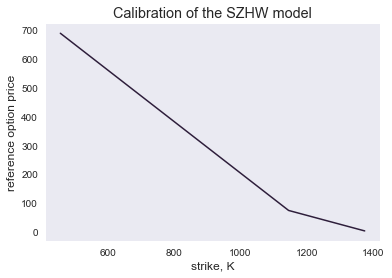

In [6]:
#%%
"""
Created on Feb 27 2019
The SZHW and the H1-HW models with the calibration that takes place for 
a single maturity. 
@author: Lech A. Grzelak
"""
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.stats as st
import scipy.special as sp
import enum 
import scipy.optimize as optimize
from scipy.optimize import minimize

# Set i= imaginary number

i   = np.complex(0.0,1.0)

# Time step 

dt = 0.0001
 
# This class defines puts and calls

class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0
    
def CallPutOptionPriceCOSMthd_StochIR(cf,CP,S0,tau,K,N,L,P0T):


    # cf   - Characteristic function is a function, in the book denoted by \varphi
    # CP   - C for call and P for put
    # S0   - Initial stock price
    # tau  - Time to maturity
    # K    - List of strikes
    # N    - Number of expansion terms
    # L    - Size of truncation domain (typ.:L=8 or L=10)
    # P0T  - Zero-coupon bond for maturity T.

    # Reshape K to become a column vector

    if K is not np.array:
        K = np.array(K).reshape([len(K),1])
    
    # Assigning i=sqrt(-1)

    i = np.complex(0.0,1.0) 
    x0 = np.log(S0 / K)   
    
    # Truncation domain

    a = 0.0 - L * np.sqrt(tau)
    b = 0.0 + L * np.sqrt(tau)
    
    # Summation from k = 0 to k=N-1

    k = np.linspace(0,N-1,N).reshape([N,1])  
    u = k * np.pi / (b - a)  

    # Determine coefficients for put prices  

    H_k = CallPutCoefficients(OptionType.PUT,a,b,k)   
    mat = np.exp(i * np.outer((x0 - a) , u))
    temp = cf(u) * H_k 
    temp[0] = 0.5 * temp[0]    
    value = K * np.real(mat.dot(temp))     
    
    # We use the put-call parity for call options

    if CP == OptionType.CALL:
        value = value + S0 - K * P0T
        
    return value

# Determine coefficients for put prices 

def CallPutCoefficients(CP,a,b,k):
    if CP==OptionType.CALL:                  
        c = 0.0
        d = b
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        if a < b and b < 0.0:
            H_k = np.zeros([len(k),1])
        else:
            H_k      = 2.0 / (b - a) * (Chi_k - Psi_k)  
    elif CP==OptionType.PUT:
        c = a
        d = 0.0
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k      = 2.0 / (b - a) * (- Chi_k + Psi_k)               
    
    return H_k    

def Chi_Psi(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c
    
    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0)) 
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi 
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi * 
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k 
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)
    
    value = {"chi":chi,"psi":psi }
    return value
    
# Black-Scholes call option price

def BS_Call_Put_Option_Price(CP,S_0,K,sigma,tau,r):
    if K is list:
        K = np.array(K).reshape([len(K),1])
    if sigma is list:
        sigma = np.array(sigma).reshape([len(sigma),1])
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0)) 
    * tau) / (sigma * np.sqrt(tau))
    d2    = d1 - sigma * np.sqrt(tau)
    if CP == OptionType.CALL:
        value = st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r * tau)
    elif CP == OptionType.PUT:
        value = st.norm.cdf(-d2) * K * np.exp(-r * tau) - st.norm.cdf(-d1)*S_0
    return value

# Implied volatility method

def ImpliedVolatilityBlack76(CP,marketPrice,K,T,S_0):

    # To determine initial volatility we define a grid for sigma
    # and interpolate on the inverse function

    sigmaGrid = np.linspace(0.0,5.0,5000)
    optPriceGrid = BS_Call_Put_Option_Price(CP,S_0,K,sigmaGrid,T,0.0)
    sigmaInitial = np.interp(marketPrice,optPriceGrid,sigmaGrid)
    print("Strike = {0}".format(K))
    print("Initial volatility = {0}".format(sigmaInitial))
    
    # Use already determined input for the local-search (final tuning)

    func = lambda sigma: np.power(BS_Call_Put_Option_Price(CP,S_0,K,sigma,T,0.0) - marketPrice, 1.0)
    impliedVol = optimize.newton(func, sigmaInitial, tol=1e-15)
    print("Final volatility = {0}".format(impliedVol))
    if impliedVol > 2.0:
        impliedVol = 0.0
    return impliedVol


def C(u,tau,lambd):
    i     = complex(0,1)
    return 1.0/lambd*(i*u-1.0)*(1.0-np.exp(-lambd*tau))

def D(u,tau,kappa,Rxsigma,gamma):
    i=np.complex(0.0,1.0)
    a_0=-1.0/2.0*u*(i+u)
    a_1=2.0*(gamma*Rxsigma*i*u-kappa)
    a_2=2.0*gamma*gamma
    d=np.sqrt(a_1*a_1-4.0*a_0*a_2)
    g=(-a_1-d)/(-a_1+d)    
    return (-a_1-d)/(2.0*a_2*(1.0-g*np.exp(-d*tau)))*(1.0-np.exp(-d*tau))
    
def E(u,tau,lambd,gamma,Rxsigma,Rrsigma,Rxr,eta,kappa,sigmabar):
    i=np.complex(0.0,1.0)
    a_0=-1.0/2.0*u*(i+u)
    a_1=2.0*(gamma*Rxsigma*i*u-kappa)
    a_2=2*gamma*gamma
    d  =np.sqrt(a_1*a_1-4.0*a_0*a_2)
    g =(-a_1-d)/(-a_1+d)    
    
    c_1=gamma*Rxsigma*i*u-kappa-1.0/2.0*(a_1+d)
    f_1=1.0/c_1*(1.0-np.exp(-c_1*tau))+1.0/(c_1+d)*(np.exp(-(c_1+d)*tau)-1.0)
    f_2=1.0/c_1*(1.0-np.exp(-c_1*tau))+1.0/(c_1+lambd)*(np.exp(-(c_1+lambd)*tau)-1.0)
    f_3=(np.exp(-(c_1+d)*tau)-1.0)/(c_1+d)+(1.0-np.exp(-(c_1+d+lambd)*tau))/(c_1+d+lambd)
    f_4=1.0/c_1-1.0/(c_1+d)-1.0/(c_1+lambd)+1.0/(c_1+d+lambd)
    f_5=np.exp(-(c_1+d+lambd)*tau)*(np.exp(lambd*tau)*(1.0/(c_1+d)-np.exp(d*tau)/c_1)+np.exp(d*tau)/(c_1+lambd)-1.0/(c_1+d+lambd)) 

    I_1=kappa*sigmabar/a_2*(-a_1-d)*f_1
    I_2=eta*Rxr*i*u*(i*u-1.0)/lambd*(f_2+g*f_3)
    I_3=-Rrsigma*eta*gamma/(lambd*a_2)*(a_1+d)*(i*u-1)*(f_4+f_5)
    return np.exp(c_1*tau)*1.0/(1.0-g*np.exp(-d*tau))*(I_1+I_2+I_3)

def A(u,tau,eta,lambd,Rxsigma,Rrsigma,Rxr,gamma,kappa,sigmabar):
    i=np.complex(0.0,1.0)
    a_0=-1.0/2.0*u*(i+u)
    a_1=2.0*(gamma*Rxsigma*i*u-kappa)
    a_2=2.0*gamma*gamma
    d  =np.sqrt(a_1*a_1-4.0*a_0*a_2)
    g =(-a_1-d)/(-a_1+d) 
    f_6=eta*eta/(4.0*np.power(lambd,3.0))*np.power(i+u,2.0)*(3.0+np.exp(-2.0*lambd*tau)-4.0*np.exp(-lambd*tau)-2.0*lambd*tau)
    A_1=1.0/4.0*((-a_1-d)*tau-2.0*np.log((1-g*np.exp(-d*tau))/(1.0-g)))+f_6
  
    # Integration within the function A(u,tau)

    value=np.zeros([len(u),1],dtype=np.complex_)   
    N = 100
    z1 = np.linspace(0,tau,N)
    #arg =z1

    E_val=lambda z1,u: E(u,z1,lambd,gamma,Rxsigma,Rrsigma,Rxr,eta,kappa,sigmabar)
    C_val=lambda z1,u: C(u,z1,lambd)
    f    =lambda z1,u: (kappa*sigmabar+1.0/2.0*gamma*gamma*E_val(z1,u)+gamma*eta*Rrsigma*C_val(z1,u))*E_val(z1,u)
    
    value1 =integrate.trapz(np.real(f(z1,u)),z1).reshape(u.size,1)
    value2 =integrate.trapz(np.imag(f(z1,u)),z1).reshape(u.size,1)
    value  =(value1 + value2*i)
    
    """
    for k in range(0,len(u)):
       E_val=E(u[k],arg,lambd,gamma,Rxsigma,Rrsigma,Rxr,eta,kappa,sigmabar)
       C_val=C(u[k],arg,lambd)
       f=(kappa*sigmabar+1.0/2.0*gamma*gamma*E_val+gamma*eta*Rrsigma*C_val)*E_val
       value1 =integrate.trapz(np.real(f),arg)
       value2 =integrate.trapz(np.imag(f),arg)
       value[k]=(value1 + value2*i)
    """
    
    return value + A_1

def ChFSZHW(u,P0T,sigma0,tau,lambd,gamma,    Rxsigma,Rrsigma,Rxr,eta,kappa,sigmabar):
    v_D = D(u,tau,kappa,Rxsigma,gamma)
    v_E = E(u,tau,lambd,gamma,Rxsigma,Rrsigma,Rxr,eta,kappa,sigmabar)
    v_A = A(u,tau,eta,lambd,Rxsigma,Rrsigma,Rxr,gamma,kappa,sigmabar)
    
    v_0 = sigma0*sigma0
    
    hlp = eta*eta/(2.0*lambd*lambd)*(tau+2.0/lambd*(np.exp(-lambd*tau)-1.0)-1.0/(2.0*lambd)*(np.exp(-2.0*lambd*tau)-1.0))
      
    correction = (i*u-1.0)*(np.log(1/P0T(tau))+hlp)
          
    cf = np.exp(v_0*v_D + sigma0*v_E + v_A + correction)
    return cf.tolist()

# Exact expectation E(sqrt(V(t)))

def meanSqrtV_3(kappa,v0,vbar,gamma):
    delta = 4.0 *kappa*vbar/gamma/gamma
    c= lambda t: 1.0/(4.0*kappa)*gamma*gamma*(1.0-np.exp(-kappa*(t)))
    kappaBar = lambda t: 4.0*kappa*v0*np.exp(-kappa*t)/(gamma*gamma*(1.0-np.exp(-kappa*t)))
    temp1 = lambda t: np.sqrt(2.0*c(t))* sp.gamma((1.0+delta)/2.0)/sp.gamma(delta/2.0)*sp.hyp1f1(-0.5,delta/2.0,-kappaBar(t)/2.0)
    return temp1

def C_H1HW(u,tau,lambd):
    i = np.complex(0.0,1.0)
    C = (i*u - 1.0)/lambd * (1-np.exp(-lambd*tau))
    return C

def D_H1HW(u,tau,kappa,gamma,rhoxv):
    i = np.complex(0.0,1.0)
    
    D1 = np.sqrt(np.power(kappa-gamma*rhoxv*i*u,2)+(u*u+i*u)*gamma*gamma)
    g  = (kappa-gamma*rhoxv*i*u-D1)/(kappa-gamma*rhoxv*i*u+D1)
    D  = (1.0-np.exp(-D1*tau))/(gamma*gamma*(1.0-g*np.exp(-D1*tau)))\
        *(kappa-gamma*rhoxv*i*u-D1)
    return D
    
def A_H1HW(u,tau,P0T,lambd,eta,kappa,gamma,vbar,v0,rhoxv,rhoxr):
    i  = np.complex(0.0,1.0)
    D1 = np.sqrt(np.power(kappa-gamma*rhoxv*i*u,2)+(u*u+i*u)*gamma*gamma)
    g  = (kappa-gamma*rhoxv*i*u-D1)/(kappa-gamma*rhoxv*i*u+D1)
    
    # Function theta(t)

    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2.0*dt)
    theta = lambda t: 1.0/lambd * (f0T(t+dt)-f0T(t-dt))/(2.0*dt) + f0T(t) + eta*eta/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))  

    # Integration within the function I_1

    N  = 500
    z  = np.linspace(0,tau-1e-10,N)
    f1 = (1.0-np.exp(-lambd*z))*theta(tau-z)
    value1 = integrate.trapz(f1,z)
    
    # Note that I_1_adj also allows time-dependent theta 
    # Therefore it is not exactly the same as in the book

    I_1_adj = (i*u-1.0) * value1
    I_2     = tau/(gamma**2.0) *(kappa-gamma*rhoxv*i*u-D1) - 2.0/(gamma**2.0)*np.log((1.0-g*np.exp(-D1*tau))/(1.0-g))
    I_3     = 1.0/(2.0*np.power(lambd,3.0))* np.power(i+u,2.0)*(3.0+np.exp(-2.0*lambd*tau)-4.0*np.exp(-lambd*tau)-2.0*lambd*tau)
    
    meanSqrtV = meanSqrtV_3(kappa,v0,vbar,gamma)
    f2        = meanSqrtV(tau-z)*(1.0-np.exp(-lambd*z))
    value2    = integrate.trapz(f2,z)
    I_4       = -1.0/lambd * (i*u+u**2.0)*value2
    
    return I_1_adj + kappa*vbar*I_2 + 0.5*eta**2.0*I_3+eta*rhoxr*I_4

def ChFH1HWModel(P0T,lambd,eta,tau,kappa,gamma,vbar,v0,rhoxv, rhoxr):
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2.0*dt)
    r0 =f0T(0.00001)
    C = lambda u: C_H1HW(u,tau,lambd)
    D = lambda u: D_H1HW(u,tau,kappa,gamma,rhoxv)
    A = lambda u: A_H1HW(u,tau,P0T,lambd,eta,kappa,gamma,vbar,v0,rhoxv,rhoxr)
    cf = lambda u: np.exp(A(u) + C(u)*r0 + D(u)*v0 )
    return cf

# Calibration of the SZHW model 

def calibrationSZHW(CP,kappa,Rxr,eta,lambd,K,marketPrice,S0,T,P0T):
    K = np.array(K)
    marketPrice = np.array(marketPrice)
    # x = [gamma,sigmaBar,Rrsigma,Rxsigma,sigma0]
    f_obj = lambda x: TargetValSZHW(CP,kappa,x[0],x[1],Rxr,x[2],x[3],x[4],eta,lambd,K,marketPrice,S0,T,P0T)
    
    # Random initial guess

    #[gamma,sigmaBar,Rrsigma,Rxsigma,sigma0
    initial = np.array([0.1, 0.1, 0.0,-0.5,0.1])
    pars  = minimize(f_obj,initial,method='nelder-mead', options = \
                     {'xtol': 1e-05, 'disp': False,'maxiter':20})
    print(pars)
    
    gamma_est = pars.x[0]
    sigmaBar_est = pars.x[1]
    Rrsigma_est = pars.x[2]
    Rxsigma_est = pars.x[3]
    sigma0_est = pars.x[4]
    parmCalibr =  {"gamma":gamma_est,"sigmaBar":sigmaBar_est,"Rrsigma":Rrsigma_est,\
                   "Rxsigma":Rxsigma_est,"sigma0":sigma0_est,'ErrorFinal':pars.fun}
    return parmCalibr

# Calibration of the SZHW model 

def calibrationSZHW_Global(CP,kappa,Rxr,eta,lambd,K,marketPrice,S0,T,P0T):
    K = np.array(K)
    marketPrice = np.array(marketPrice)
    # x = [gamma,sigmaBar,Rrsigma,Rxsigma,sigma0]
    f_obj = lambda x: TargetValSZHW(CP,kappa,x[0],x[1],Rxr,x[2],x[3],x[4],eta,lambd,K,marketPrice,S0,T,P0T)
    
    # Random initial guess

    #[gamma,sigmaBar,Rrsigma,Rxsigma,sigma0
    initial = np.array([0.1, 0.1,0.0,-0.5,0.3])
    
    # The bounds

    xmin = [0.1, 0.01,-0.85, -0.85, 0.01]
    xmax = [0.8,  0.4, 0.85, -0.0, 0.8]    
    
    # Rewrite the bounds as required by L-BFGS-B
    bounds = [(low, high) for low, high in zip(xmin, xmax)]

    # Use L-BFGS-B method because the problem is smooth and bounded

    minimizer_kwargs = dict(method="L-BFGS-B", bounds=bounds,options={'niter':1})

    # Global search

    pars = optimize.basinhopping(f_obj, initial,niter=1, minimizer_kwargs=minimizer_kwargs)
    
    gamma_est = pars.x[0]
    sigmaBar_est = pars.x[1]
    Rrsigma_est = pars.x[2]
    Rxsigma_est = pars.x[3]
    sigma0_est = pars.x[4]
    print("=======================Start local search!========================")
    print(pars)

    # Use global parameters in the local search

    initial =[gamma_est,sigmaBar_est,Rrsigma_est,Rxsigma_est,sigma0_est] 
    pars  = minimize(f_obj,initial,method='nelder-mead', options = \
                     {'xtol': 1e-05, 'disp': False,'maxiter':20})
    print(pars)
    
    gamma_est = pars.x[0]
    sigmaBar_est = pars.x[1]
    Rrsigma_est = pars.x[2]
    Rxsigma_est = pars.x[3]
    sigma0_est = pars.x[4]
    parmCalibr =  {"gamma":gamma_est,"sigmaBar":sigmaBar_est,"Rrsigma":Rrsigma_est,\
                   "Rxsigma":Rxsigma_est,"sigma0":sigma0_est,'ErrorFinal':pars.fun}
    return parmCalibr

# Global calibration of the Heston Hull-White model 

def calibrationH1HW_Global(CP,kappa,Rxr,eta,lambd,K,marketPrice,S0,T,P0T):
    K = np.array(K)
    marketPrice = np.array(marketPrice)
    # x = [gamma,vBar,Rxv,v0]
    f_obj = lambda x: TargetValH1HW(CP,kappa,x[0],x[1],Rxr,x[2],x[3],eta,lambd,K,marketPrice,S0,T,P0T)
       
    # Random initial guess

    #[gamma,vBar,Rxv,v0]
    initial = np.array([1.0, 0.05,-0.7, 0.05])
    
    # The bounds

    xmin = [0.1, 0.001,-0.99, 0.001]
    xmax = [0.8,  0.4,  -0.3, 0.4]    
    
    # Rewrite the bounds as required by L-BFGS-B

    bounds = [(low, high) for low, high in zip(xmin, xmax)]

    # Use L-BFGS-B method because the problem is smooth and bounded

    minimizer_kwargs = dict(method="L-BFGS-B", bounds=bounds,options={'niter':1})

    # Global search

    pars = optimize.basinhopping(f_obj, initial,niter=1, minimizer_kwargs=minimizer_kwargs)
    
    print(pars)
    
    # Use global parameters in the local search

    gamma_est = pars.x[0]
    vBar_est = pars.x[1]
    Rxv_est = pars.x[2]
    v0_est = pars.x[3]
    initial = [gamma_est,vBar_est,Rxv_est,v0_est]    
    pars  = minimize(f_obj,initial,method='nelder-mead', options = \
                     {'xtol': 1e-05, 'disp': False,'maxiter':200})
    
    gamma_est = pars.x[0]
    vBar_est = pars.x[1]
    Rxv_est = pars.x[2]
    v0_est = pars.x[3]
    parmCalibr =  {"gamma":gamma_est,"vBar":vBar_est,"Rxv":Rxv_est,\
                   "v0":v0_est,'ErrorFinal':pars.fun}
    return parmCalibr

# Calibration of the Heston Hull-White model 

def calibrationH1HW(CP,kappa,Rxr,eta,lambd,K,marketPrice,S0,T,P0T):
    K = np.array(K)
    marketPrice = np.array(marketPrice)
    # x = [gamma,vBar,Rxv,v0]
    f_obj = lambda x: TargetValH1HW(CP,kappa,x[0],x[1],Rxr,x[2],x[3],eta,lambd,K,marketPrice,S0,T,P0T)
       
    # Random initial guess

    #[gamma,vBar,Rxv,v0]
    initial = np.array([1.0, 0.05,-0.7, 0.05])
    pars  = minimize(f_obj,initial,method='nelder-mead', options = \
                     {'xtol': 1e-05, 'disp': False,'maxiter':100})
    print(pars)
    
    gamma_est = pars.x[0]
    vBar_est = pars.x[1]
    Rxv_est = pars.x[2]
    v0_est = pars.x[3]
    parmCalibr =  {"gamma":gamma_est,"vBar":vBar_est,"Rxv":Rxv_est,\
                   "v0":v0_est,'ErrorFinal':pars.fun}
    return parmCalibr

def TargetValSZHW(CP,kappa,gamma,sigmaBar,Rxr,Rrsigma,Rxsigma,sigma0,eta,lambd,K,marketPrice,S0,T,P0T):
    if K is not np.array:
        K = np.array(K).reshape([len(K),1])
    
    # Setting additional constraints

    if gamma>1.0 or sigmaBar>1.0 or np.abs(Rxsigma)>1.0:
        return 10e10
    
    # Settings for the COS method

    N = 500
    L = 15  
    cf = lambda u: ChFSZHW(u,P0T,sigma0,T,lambd,gamma,Rxsigma,Rrsigma,Rxr,eta,kappa,sigmaBar)
    valCOS = CallPutOptionPriceCOSMthd_StochIR(cf, CP, S0, T, K, N, L,P0T(T))
    
    # Error is defined as the difference between the market and the model

    errorVector = valCOS - marketPrice
    
    # Target value is a norm of the error vector

    value       = np.linalg.norm(errorVector)   
#     print("Total Error = {0}".format(value))
    return value

def TargetValH1HW(CP,kappa,gamma,vBar,Rxr,Rxv,v0,eta,lambd,K,marketPrice,S0,T,P0T):
    if K is not np.array:
        K = np.array(K).reshape([len(K),1])
    
    # Settings for the COS method

    N = 2000
    L = 15  
    cf = ChFH1HWModel(P0T,lambd,eta,T,kappa,gamma,vBar,v0, Rxv, Rxr)
    valCOS = CallPutOptionPriceCOSMthd_StochIR(cf, CP, S0, T, K, N, L,P0T(T))
    
    # Error is defined as the difference between the market and the model

    errorVector = valCOS - marketPrice
    
    # Target value is a norm of the error vector

    value       = np.linalg.norm(errorVector)   
#     print("Total Error = {0}".format(value))
    return value

def mainCalculation():
    CP  = OptionType.CALL  
        
    # HW model parameter settings

    lambd = 0.01
    eta   = 0.01
    S0    = 1145.88       
   
    # Fixed SZHW / H1-HW model parameters

    kappa =  0.5
    Rxr   =  0.3
      
    # We define a ZCB curve (obtained from the market)
    # This curve is based on the estimation to real market data

    P0T = lambda T: np.exp(0.0012*T+0.0007) 
       
    # Settings for the COS method

    N = 2000
    L = 15  
    
    ################## Here we define market call option prices #################
    
    T = 0.5
    referenceIV  = np.array([57.61, 22.95, 15.9])/100.0
    
    #T = 1.0
    #referenceIV = np.array([48.53, 24.49, 19.23])/100.0
        
    #T = 10.0
    #referenceIV = np.array([36.76, 29.18, 27.66])/100.0
    
    # Strike range

    frwd = S0/P0T(T)
    K = [0.4*frwd, frwd, 1.2*frwd]
    K = np.array(K).reshape([len(K),1])
    
    referenceIV = np.array(referenceIV).reshape([len(referenceIV),1])
    referencePrice = P0T(T)* BS_Call_Put_Option_Price(CP,S0 / P0T(T),K,referenceIV,T,0.0)
    
    
    plt.figure(1)
    plt.title('Calibration of the SZHW model')
    plt.plot(K,referencePrice)
    plt.xlabel('strike, K')
    plt.ylabel('reference option price')
    plt.grid()
    
    # Calibrate the SZHW model and show the output

    calibratedParms = calibrationSZHW_Global(CP,kappa,Rxr,eta,lambd,K,referencePrice,S0,T,P0T)

    # Plot calibrated SZHW prices          

    gamma    = calibratedParms.get('gamma')
    sigmaBar = calibratedParms.get('sigmaBar')
    Rrsigma  = calibratedParms.get('Rrsigma')
    Rxsigma  = calibratedParms.get('Rxsigma')
    sigma0   = calibratedParms.get('sigma0')   
    errorSZHW =calibratedParms.get('ErrorFinal')   
    cf = lambda u: ChFSZHW(u,P0T,sigma0,T,lambd,gamma,Rxsigma,Rrsigma,Rxr,eta,kappa,sigmaBar)
    valCOS_SZHW = CallPutOptionPriceCOSMthd_StochIR(cf, CP, S0, T, K, N, L,P0T(T))
    plt.plot(K,valCOS_SZHW,'--r')
    plt.legend(['Input','Calibration output'])
    
    print("Optimal parameters for SZHW are: gamma = {0:.3f}, sigmaBar = {1:.3f}, Rrsigma \
          = {2:.3f}, Rxsigma = {3:.3f}, sigma0 = {4:.3f}".format(gamma,\
          sigmaBar,Rrsigma,Rxsigma,sigma0))
        
    # Calibrate the H1HW model and show the output

    plt.figure(2)
    plt.title('Calibration of the H1HW model')
    plt.plot(K,referencePrice)
    plt.xlabel('strike, K')
    plt.ylabel('reference option price')
    plt.grid()
    
    calibratedParms =  calibrationH1HW_Global(CP,kappa,Rxr,eta,lambd,K,referencePrice,S0,T,P0T)
    
    gamma = calibratedParms.get('gamma')
    vBar  = calibratedParms.get('vBar')
    Rxv   = calibratedParms.get('Rxv')
    v0    = calibratedParms.get('v0')
    errorH1HW = calibratedParms.get('ErrorFinal')   
    
    cf2 = ChFH1HWModel(P0T,lambd,eta,T,kappa,gamma,vBar,v0,Rxv, Rxr)
    valCOS_H1HW = CallPutOptionPriceCOSMthd_StochIR(cf2, CP, S0, T, K, N, L,P0T(T))
    
    plt.plot(K,valCOS_H1HW,'--r')
    plt.legend(['Input','Calibration output'])
    
    
    print("Optimal parameters for H1-HW are: gamma = {0:.3f}, vBar = {1:.3f}, Rxv = {2:.3f}, v0 = {3:.3f}".format(gamma,vBar,Rxv,v0))
    print("=======================================================================")
    print('Final error for SZHW ={0} and for H1HW={1}'.format(errorSZHW,errorH1HW))
    
    # Plot implied volatilities for both models    

    IVH1HW =np.zeros([len(K),1])
    IVSZHW =np.zeros([len(K),1])
    IVMarket =np.zeros([len(K),1])
    for (idx,k) in enumerate(K):
        IVMarket[idx] = ImpliedVolatilityBlack76(CP,referencePrice[idx]/P0T(T),k,T,S0/P0T(T))*100.0
        IVH1HW[idx] = ImpliedVolatilityBlack76(CP,valCOS_H1HW[idx]/P0T(T),k,T,S0/P0T(T))*100.0
        IVSZHW[idx] = ImpliedVolatilityBlack76(CP,valCOS_SZHW[idx]/P0T(T),k,T,S0/P0T(T))*100.0
    
    plt.figure(3)
    plt.plot(K,IVMarket)
    plt.plot(K,IVH1HW,'--r')
    plt.plot(K,IVSZHW)
    plt.grid()
    plt.legend(['market','H1HW','SZHW'])
    
    print('Market IV')
    print(IVMarket)
    print('H1HW IV')
    print(IVH1HW)
    print('SZHW IV')
    print(IVSZHW)
    
mainCalculation()



In [13]:
# v0, kappa, gamma, vbar, rho0, kp, mup, sigmap, rho2

def error_heston_stoch_corr_AES(x, prices, K, s0):
    paths = mcm.heston_stoch_corr_AES(numberPaths, N, s0, x[0], T, x[1], x[2], x[3], x[4], r, x[5], x[6], x[7], rho1, x[8])[1]
    
    price_calib = mcm.optionPriceMCGeneral(type_option, paths[:, -1], K, T, r)
    
    return sum(((price_calib - prices)/apple_spread)**2)/len(prices)

In [565]:
init_vals = [0.04, 2, 0.2, 0.02, -0.8, 4, 0.2, 0.4, 0.02]
bounds = ((0.01, 5), (1, 5), (0.5, 1), (0.01, 5), (-0.9, 0.9), (3, 5), (0.1, 1), (0.01, 0.4), (0.01, 0.08))

params_heston_AES = minimize(error_heston_stoch_corr_AES, x0=init_vals, args=(apple_market_price, apple_strikes, s0_apple, spread),
                             bounds=bounds, tol=1e-4, options={"maxiter": 1000})
params_heston_AES

      fun: nan
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.14152285e+12,  1.70027185e+12,  1.76700558e+12,  3.11887014e+12,
        3.73929715e+12,  1.97235960e+12,  9.25205290e+11, -2.80021614e+12,
        2.34097609e+12])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 20
      nit: 0
     njev: 2
   status: 2
  success: False
        x: array([ 0.04,  2.  ,  0.5 ,  0.02, -0.8 ,  4.  ,  0.2 ,  0.4 ,  0.02])

In [547]:
v0, kappa, gamma, vbar, rho0, kp, mup, sigmap, rho2 = params_heston_AES.x

In [548]:
paths_heston_AES = mcm.heston_stoch_corr_AES(numberPaths, N, s0_apple, v0, T, kappa, gamma, vbar, rho0, r, kp, mup, sigmap, rho1, rho2)[1]

In [549]:
option_heston_AES = mcm.optionPriceMCGeneral(type_option, paths_heston_AES[:,-1], apple_strikes, T, r)

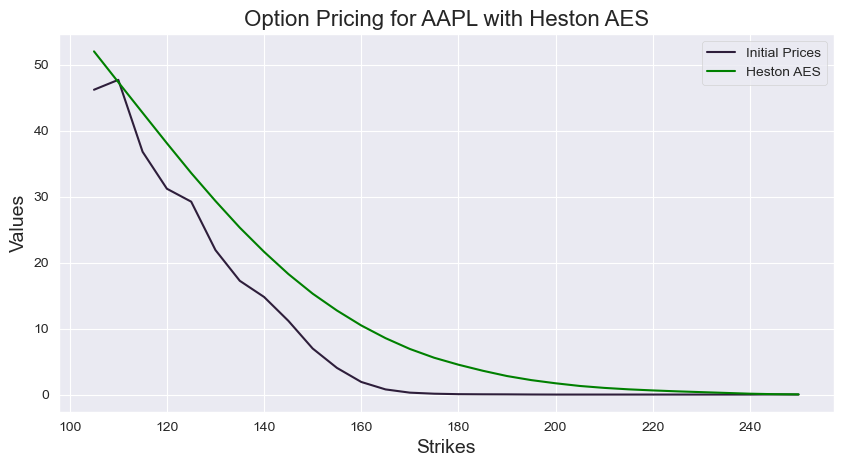

In [550]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(apple_strikes, apple_market_price, label='Initial Prices')
plt.plot(apple_strikes, option_heston_AES, color='green', label='Heston AES')
        
plt.title('Option Pricing for AAPL with Heston AES', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [409]:
tsla = ops.get_calls("TSLA", 'April 1, 2022')

In [410]:
# tsla.to_csv('tsla_option_call_april_01_2022.csv')

In [411]:
s0_tsla = 766.37 #15.03.2022

In [412]:
tsla_strikes = tsla.loc[:, 'Strike']
tsla_market_price = tsla.loc[:, 'Last Price']

In [423]:
init_vals = [0.04, 2, 0.2, 0.02, -0.8, 4, 0.2, 0.4, 0.02]
bounds = ((0.01, 0.1), (0, 5), (0, 1), (0.01, 0.1), (-0.9, 0.9), (3, 5), (0.01, 1), (0.01, 0.5), (0.01, 0.08))

params_heston_AES = minimize(error_heston_stoch_corr_AES, x0=init_vals, args=(tsla_market_price, tsla_strikes, s0_tsla), bounds=bounds, tol=1e-10, options={"maxiter": 2000})
params_heston_AES

/Users/kirillzakharov/Desktop/Stochastic Calculus/monte_carlo_methods.py:173: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1- (rho[:, t])**2 - ((rho2-rho1*rho[:, t])/np.sqrt(1-rho1**2))**2)*np.sqrt(V[:, t]) * np.sqrt(dt) * Zx[:, t]


      fun: nan
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.34896949e+12, -2.17063453e+12, -4.47419204e+12, -3.56736088e+12,
       -4.18361986e+12, -2.77998814e+12, -5.39473593e+12, -1.63114535e+12,
       -2.20910285e+12])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 20
      nit: 0
     njev: 2
   status: 2
  success: False
        x: array([ 0.04,  2.  ,  0.2 ,  0.02, -0.8 ,  4.  ,  0.2 ,  0.4 ,  0.02])

In [424]:
v0, kappa, gamma, vbar, rho0, kp, mup, sigmap, rho2 = params_heston_AES.x

In [425]:
paths_heston_AES = mcm.heston_stoch_corr_AES(numberPaths, N, s0_tsla, v0, T, kappa, gamma, vbar, rho0, r, kp, mup, sigmap, rho1, rho2)[1]

In [426]:
option_heston_AES = mcm.optionPriceMCGeneral(type_option, paths_heston_AES[:, -1], tsla_strikes, T, r)

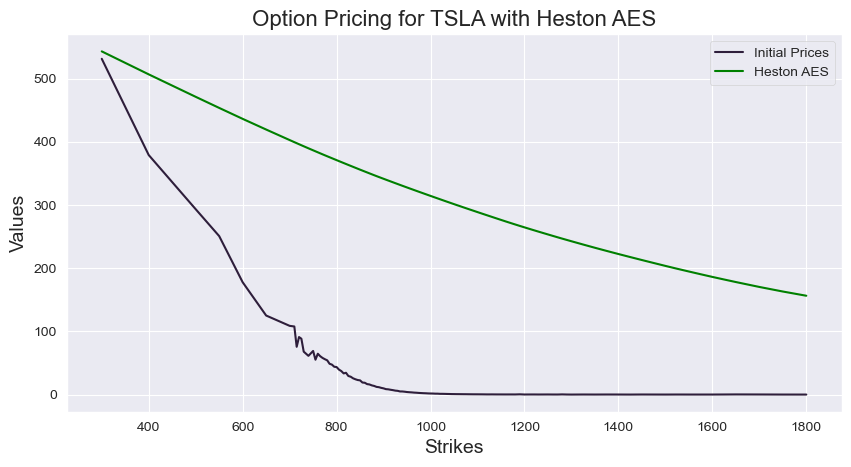

In [427]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(tsla_strikes, tsla_market_price, label='Initial Prices')
plt.plot(tsla_strikes, option_heston_AES, color='green', label='Heston AES')
        
plt.title('Option Pricing for TSLA with Heston AES', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [428]:
s0 = 100
sigma = 0.5
T = 20

In [429]:
process = stch.StochasticProcesses()
gbm = process.geometric_BM(T, s0, r, sigma, T)

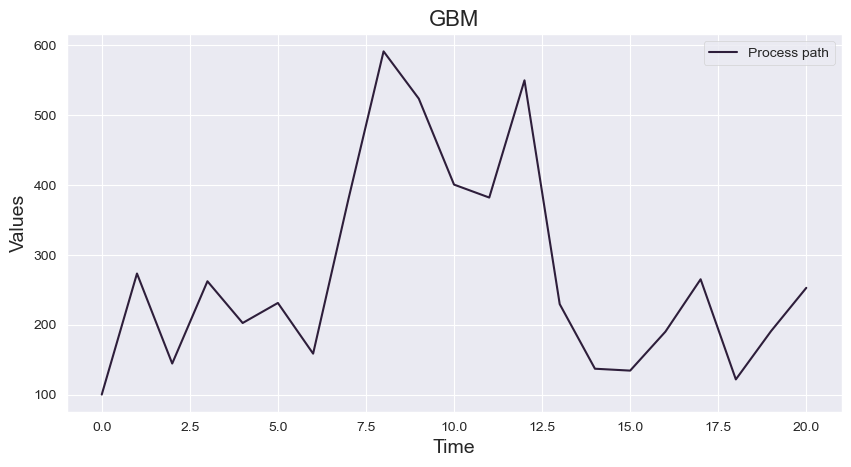

In [430]:
time = gbm[0]
process.plot_path(time, gbm[1], title='GBM')

### Black-Scholes

In [468]:
K1 = np.array([110])
# K1 = [110, 120, 125]
r = 0.05
s0 = 100
T = 20

N = T

In [469]:
options_BS_time = []

for t in range(T):
    options_BS_time.append(exm.BS_Call_Option_Price(type_option, gbm[1][t], K1, sigma, T-t, r))
    
options_BS_time = np.array(options_BS_time)

### Heston AES

In [487]:
# v0, kappa, gamma, vbar, rho0, kp, mup, sigmap, rho2

def error_heston_stoch_corr_AES(x, prices, K, s0, T):
#     paths = mcm.heston_stoch_corr_AES(numberPaths, N, s0, x[0], T, x[1], x[2], x[3], x[4], r, x[5], x[6], x[7], rho1, x[8])[1]
    
#     price_calib = mcm.optionPriceMCGeneral(type_option, paths[:, -1], K, T, r)
    price_calib = []
    for t in range(1, T+1):
        paths = mcm.heston_stoch_corr_AES(numberPaths, t, s0, x[0], t, x[1], x[2], x[3], x[4], r, x[5], x[6], x[7], rho1, x[8])[1]
    
        price_calib.append(mcm.optionPriceMCGeneral(type_option, paths[:, -1], K, t, r))
    price_calib = np.array(price_calib)
#     print(price_calib)
    
    return np.mean((price_calib - prices)**2)

In [497]:
init_vals = [0.04, 2, 0.2, 0.02, -0.8, 4, 0.2, 0.4, 0.02]
bounds = ((0.01, 0.1), (0, 5), (0.2, 1), (0.01, 0.1), (-0.9, 0.9), (3, 5), (0.01, 1), (0.01, 0.5), (0.01, 0.08))

params_heston_AES = minimize(error_heston_stoch_corr_AES, x0=init_vals, args=(options_BS_time, K1, s0, T), bounds=bounds, tol=1e-5, options={"maxiter": 2000})
params_heston_AES

      fun: nan
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.69398370e+10, -2.79700959e+10,             nan,  1.91678080e+10,
       -1.74874569e+10,  1.13026234e+10, -9.09178910e+09, -2.97080936e+10,
       -4.82536373e+10])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 380
      nit: 2
     njev: 38
   status: 2
  success: False
        x: array([ 0.04000001,  2.00000021,  0.20000006,  0.02      , -0.80000001,
        4.00000008,  0.19999998,  0.39999998,  0.02      ])

In [490]:
v0, kappa, gamma, vbar, rho0, kp, mup, sigmap, rho2 = params_heston_AES.x

In [491]:
option_heston_AES = []

for t in range(T):
    paths_heston_AES = mcm.heston_stoch_corr_AES(500, N, s0, v0, t, kappa, gamma, vbar, rho0, r, kp, mup, sigmap, rho1, rho2)[1]
    option_heston_AES.append(mcm.optionPriceMCGeneral(type_option, paths_heston_AES[:, -1], [K1], t, r))
    
option_heston_AES = np.array(option_heston_AES).T[0]  

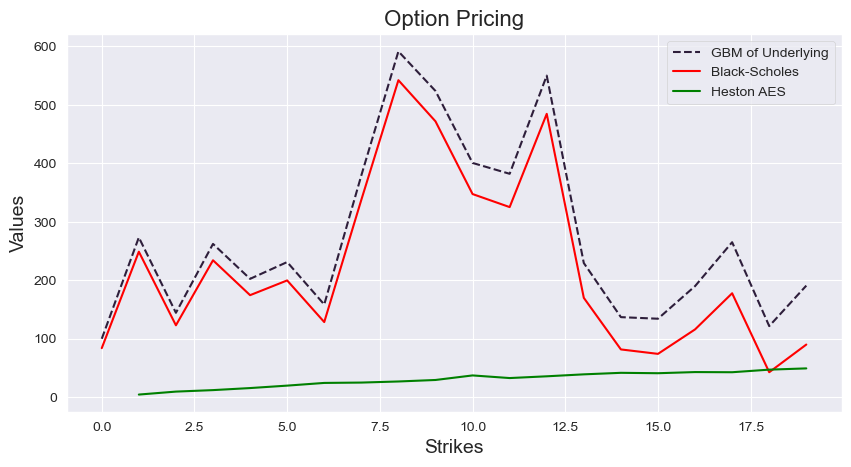

In [492]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(gbm[1][:-1], '--', label='GBM of Underlying')
plt.plot(options_BS_time, c='red', label='Black-Scholes')
plt.plot(option_heston_AES, c='green', label='Heston AES')
        
plt.title('Option Pricing', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [493]:
option_heston_AES

array([        nan,  4.62390236,  9.69188708, 12.23667668, 15.73569543,
       19.90756675, 24.52200305, 25.12859118, 26.99585068, 29.55637207,
       37.34396416, 32.84857732, 35.84513213, 39.19583837, 41.79514592,
       41.12057674, 43.08000651, 42.81058126, 47.22765408, 49.37531783])